# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassAccuracy
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Check if CUDA (GPU) is available and set the device accordingly.
device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
print(f"Using device: {device}")

Using device: cpu


# Data Loading

In [2]:
# Set up the label encoder for consistency in target labels
le = LabelEncoder()
labels = ['Benign', 'DDoS', 'Reconnaissance', 'injection', 'DoS', 'Brute Force', 'password', 'xss', 'Infilteration', 'Exploits', 'scanning', 'Fuzzers', 'Backdoor', 'Bot', 'Generic', 'Analysis', 'Theft', 'Shellcode', 'mitm', 'Worms', 'ransomware']
le.fit(labels)

LabelEncoder()

In [3]:
class NFUQNIDS(Dataset):
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)

        # Attack type as target label
        self.labels = self.data['Attack']
        self.labels = le.transform(self.labels)

        self.data.drop('Attack', axis=1, inplace=True)
        self.data.drop('Label', axis=1, inplace=True, errors='ignore')

        self.data = self.data.values

        print(self.data)
        print(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx], dtype=torch.float32, device=device)
        label = torch.tensor(self.labels[idx], dtype=torch.float32, device=device)
        label = label.type(torch.LongTensor).to(device)

        return features, label

In [4]:
# Real attack data
real_attack_data = NFUQNIDS('data/cleaned/NF-UQ-NIDS-ATTACKS.csv')

train_size = int(0.8 * len(real_attack_data))
val_size = len(real_attack_data) - train_size
real_train_dataset, real_val_dataset = torch.utils.data.random_split(real_attack_data, [train_size, val_size])

# Synthetic attack data
synth_attack_data = NFUQNIDS('data/synthetic/NF-UQ-NIDS-ATTACKS-SYNTHETIC.csv')

train_size = int(0.8 * len(synth_attack_data))
val_size = len(synth_attack_data) - train_size
synth_train_dataset, synth_val_dataset = torch.utils.data.random_split(synth_attack_data, [train_size, val_size])

[[4.3025e+04 2.5000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [6.4923e+04 8.0000e+01 6.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [9.0220e+03 1.1100e+02 6.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [5.0032e+04 4.4330e+03 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [4.4440e+03 4.9160e+04 6.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [4.4330e+03 5.0032e+04 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[ 7  7 11 ... 13 13 13]
[[0.0000e+00 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [0.0000e+00 1.1100e+02 6.0000e+00 ... 1.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [1.0430e+03 8.0000e+01 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [6.5312e+04 5.2000e+02 6.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [8.5670e+03 2.5000e+01 1.7000e+01 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
[8 9 8 ... 0 6 7]


In [5]:
batch_size = 4096

real_train = DataLoader(real_train_dataset, batch_size=batch_size, shuffle=True)
real_val = DataLoader(real_val_dataset, batch_size=batch_size, shuffle=True)

synth_train = DataLoader(synth_train_dataset, batch_size=batch_size, shuffle=True)
synth_val = DataLoader(synth_val_dataset, batch_size=batch_size, shuffle=True)

del real_train_dataset
del real_val_dataset
del synth_train_dataset
del synth_val_dataset

# Model Definition

In [6]:
# Model hyperparameters
input_dim = 74
hidden_dim = input_dim*2
num_classes = 21

# Model definition
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

In [7]:
# Train the synthetic model
synth_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(synth_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
synth_train_loss_list = []
synth_val_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0

    for inputs, labels in synth_train:
        # Calculate training output and loss
        train_outputs = synth_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(synth_train))
    synth_train_loss_list.append(cumulative_train_loss)

    synth_model.eval()
    with torch.no_grad():
        for inputs, labels in synth_val:
            # Calculate training output and loss
            val_outputs = synth_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss
        
    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(synth_val))
    synth_val_loss_list.append(cumulative_val_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

 15%|█▌        | 15/100 [00:00<00:02, 32.25it/s]

Epoch [10/100], Train Loss: 84.4328, Validation Loss: 107.6498


 23%|██▎       | 23/100 [00:00<00:02, 32.39it/s]

Epoch [20/100], Train Loss: 49.6313, Validation Loss: 65.7279


 35%|███▌      | 35/100 [00:01<00:01, 32.69it/s]

Epoch [30/100], Train Loss: 30.4560, Validation Loss: 42.4571


 43%|████▎     | 43/100 [00:01<00:01, 32.60it/s]

Epoch [40/100], Train Loss: 29.3867, Validation Loss: 40.3621


 55%|█████▌    | 55/100 [00:01<00:01, 32.75it/s]

Epoch [50/100], Train Loss: 21.7659, Validation Loss: 27.1333


 63%|██████▎   | 63/100 [00:01<00:01, 32.91it/s]

Epoch [60/100], Train Loss: 15.6493, Validation Loss: 31.9078


 75%|███████▌  | 75/100 [00:02<00:00, 33.27it/s]

Epoch [70/100], Train Loss: 16.5651, Validation Loss: 29.4767


 83%|████████▎ | 83/100 [00:02<00:00, 33.60it/s]

Epoch [80/100], Train Loss: 12.9340, Validation Loss: 20.5276


 95%|█████████▌| 95/100 [00:02<00:00, 33.78it/s]

Epoch [90/100], Train Loss: 14.3977, Validation Loss: 27.0371


100%|██████████| 100/100 [00:03<00:00, 33.01it/s]

Epoch [100/100], Train Loss: 13.2366, Validation Loss: 23.2311


In [8]:
# Train the real model
real_model = Classifier(input_dim, hidden_dim, num_classes).to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(real_model.parameters(), lr=0.001)

num_epochs = 100

# Lists to store the loss values for training and validation sets
real_train_loss_list = []
real_val_loss_list = []

for epoch in tqdm(range(num_epochs)):
    cumulative_train_loss = 0
    cumulative_val_loss = 0

    for inputs, labels in real_train:
        # Calculate training output and loss
        train_outputs = real_model(inputs)
        train_loss = criterion(train_outputs, labels)

        cumulative_train_loss = cumulative_train_loss + train_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
    # Calculate training loss this epoch
    cumulative_train_loss = cumulative_train_loss.item() / (len(real_train))
    real_train_loss_list.append(cumulative_train_loss)

    real_model.eval()
    with torch.no_grad():
        for inputs, labels in real_val:
            # Calculate training output and loss
            val_outputs = real_model(inputs)
            val_loss = criterion(val_outputs, labels)

        cumulative_val_loss = cumulative_val_loss + val_loss
        
    # Calculate val loss this epoch
    cumulative_val_loss = cumulative_val_loss.item() / (len(real_val))
    real_val_loss_list.append(cumulative_val_loss)

    if(((epoch+1) % 10) == 0):
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {(cumulative_train_loss):.4f}, Validation Loss: {(cumulative_val_loss):.4f}')

  5%|▌         | 5/100 [08:47<2:46:59, 105.47s/it]


KeyboardInterrupt: 

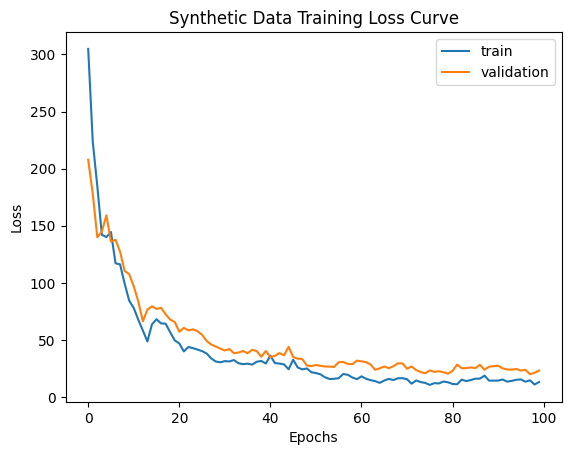

In [9]:
# Plot the synthetic loss curve
plt.plot(synth_train_loss_list, label="train")
plt.plot(synth_val_loss_list, label="validation")
plt.title("Synthetic Data Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

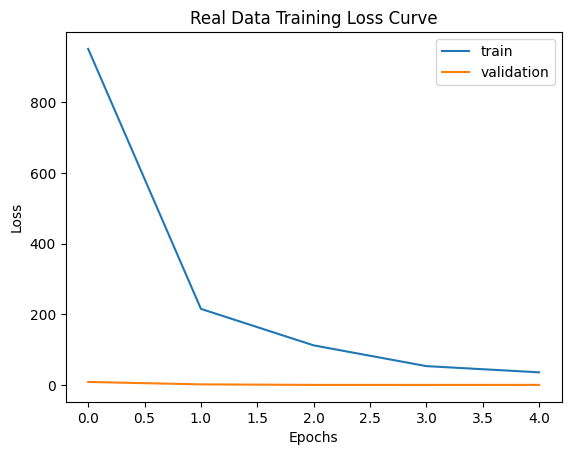

In [10]:
# Plot the real loss curve
plt.plot(real_train_loss_list, label="train")
plt.plot(real_val_loss_list, label="validation")
plt.title("Real Data Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
# Save the models
torch.save(synth_model.state_dict, 'models/synth_attack_classifier')
torch.save(real_model.state_dict, 'models/real_attack_classifier')

# Model Evaluation

In [13]:
# Evaluation
synth_model.eval()
real_model.eval()
with torch.no_grad():
    synth_metric = MulticlassAccuracy(num_classes=num_classes)
    real_metric = MulticlassAccuracy(num_classes=num_classes)
    synth_accuracy = 0
    real_accuracy = 0
    num = 0

    for inputs, labels in real_val:
        # Synth
        synth_outputs = synth_model(inputs)
        _, predicted = torch.max(synth_outputs, 1)
        synth_metric.update(predicted, labels)
        synth_accuracy = synth_accuracy + synth_metric.compute()

        # Real
        real_outputs = real_model(inputs)
        _, predicted = torch.max(real_outputs, 1)
        real_metric.update(predicted, labels)
        real_accuracy = real_accuracy + real_metric.compute()

        num = num + 1

    synth_accuracy = synth_accuracy / num
    real_accuracy = real_accuracy / num

    print(f"Synthetic model accuracy: {synth_accuracy}")
    print(f"Real model accuracy: {real_accuracy}")

Synthetic model accuracy: 0.1549694836139679
Real model accuracy: 0.6622022986412048
